# CausalLift demo


### Please see the GitHub repository for details about CausalLift package: 

https://github.com/Minyus/causallift

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Import CausalLift

In [2]:
try:
    from google import colab
    !pip3 install causallift
except:
    import sys
    from pathlib import Path
    print('Current Working Directory: {}'.format(Path().cwd()))
    sys.path.insert(0, str(Path().cwd().parent.parent / "src"))

Current Working Directory: /home/u/Minyus/causallift/notebooks/demo


In [3]:
import causallift
causallift.__version__

'1.0.0'

In [4]:
from causallift import CausalLift

## Import other modules

In [5]:
from sklearn.model_selection import train_test_split

import pandas as pd

""" display only top 4 and bottom 4 rows of pandas Data Frame if more than 8 rows """
pd.options.display.max_rows = 8 

seed = 0

## Prepare data

In [6]:
data = 'simulated_observational_data'
# data = 'lalonde'

if data == 'simulated_observational_data':
    """
    # Generate simulated data
    # "Sleeping dogs" (a.k.a. "do-not-disturb"; people who will "buy" if not 
    treated but will not "buy" if treated) can be simulated by negative values 
    in tau parameter.
    # Observational data which includes confounding can be simulated by 
    non-zero values in propensity_coef parameter.  
    # A/B Test (RCT) with a 50:50 split can be simulated by all-zeros values 
    in propensity_coef parameter (default).
    # The first element in each list parameter specifies the intercept.
    """
    from causallift import generate_data

    df = generate_data( \
        N=1000, 
        n_features=3, 
        beta=[0,-2,3,-5], # Effect of [intercept and features] on outcome 
        error_std=0.1, 
        tau=[1,-5,-5,10], # Effect of [intercept and features] on treated outcome
        tau_std=0.1, 
        discrete_outcome=True, 
        seed=seed, 
        feature_effect=0, # Effect of beta on treated outxome
        propensity_coef=[0,-1,1,-1], # Effect of [intercept and features] on propensity log-odds for treatment
        index_name='index')
    
if data == 'lalonde':
    r""" 
        Lalonde dataset was used to evaluate propensity score in the paper:
        Dehejia, R., & Wahba, S. (1999). Causal Effects in Nonexperimental 
        Studies: Reevaluating the Evaluation of Training Programs. Journal of 
        the American Statistical Association, 94(448), 1053-1062. 
        doi:10.2307/2669919

        Lalonde dataset is now included in R package named "Matching."
        http://sekhon.berkeley.edu/matching/lalonde.html
    """
    import numpy as np
    
    def get_lalonde():
        r""" Load datasets, concatenate, and create features to get data frame 
        similar to 'lalonde' that comes with "Matching.")
        """
        cols = ['treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr','re74','re75','re78']
        control_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_control.txt', sep='\s+', header = None, names = cols)
        treated_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_treated.txt', sep='\s+', header = None, names = cols)
        lalonde_df = pd.concat([control_df, treated_df], ignore_index=True)
        lalonde_df['u74'] = np.where(lalonde_df['re74'] == 0, 1.0, 0.0)
        lalonde_df['u75'] = np.where(lalonde_df['re75'] == 0, 1.0, 0.0)
        return lalonde_df
    lalonde_df = get_lalonde()
    
    """ Prepare the input Data Frame. """
    df = lalonde_df.copy()
    df.rename(columns={'treat':'Treatment', 're78':'Outcome'}, inplace=True)
    df['Outcome'] = np.where(df['Outcome'] > 0, 1.0, 0.0)
    
    # categorize age to 20s, 30s, 40s, and 50s and then one-hot encode age
    df.loc[:,'age'] = df['age'].apply(lambda x:'{:.0f}'.format(x)[:-1]+'0s') 
    df = pd.get_dummies(df, columns=['age'], drop_first=True) 
    
    cols = ['nodegr', 'black', 'hisp', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 
            'educ', 'married', 'u74', 'u75', 'Treatment', 'Outcome']
    df = df[cols]
    
    

In [7]:
df

,0,1,2,Treatment,Outcome
index,,,,,
0,0.548814,0.715189,0.602763,1.0,0.0
1,0.544883,0.423655,0.645894,0.0,0.0
2,0.437587,0.891773,0.963663,0.0,0.0
3,0.383442,0.791725,0.528895,0.0,0.0
...,...,...,...,...,...
996,0.774353,0.560374,0.082494,0.0,0.0
997,0.475214,0.287293,0.879682,0.0,0.0
998,0.284927,0.941687,0.546133,1.0,0.0
999,0.323614,0.813545,0.697400,1.0,1.0


## EDA

In [8]:
df

,0,1,2,Treatment,Outcome
index,,,,,
0,0.548814,0.715189,0.602763,1.0,0.0
1,0.544883,0.423655,0.645894,0.0,0.0
2,0.437587,0.891773,0.963663,0.0,0.0
3,0.383442,0.791725,0.528895,0.0,0.0
...,...,...,...,...,...
996,0.774353,0.560374,0.082494,0.0,0.0
997,0.475214,0.287293,0.879682,0.0,0.0
998,0.284927,0.941687,0.546133,1.0,0.0
999,0.323614,0.813545,0.697400,1.0,1.0


In [9]:
pd.crosstab(df['Outcome'], df['Treatment'], margins = True)

Treatment,0.0,1.0,All
Outcome,,,
0.0,575,236,811
1.0,48,141,189
All,623,377,1000


In [10]:
df.describe()

,0,1,2,Treatment,Outcome
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.505377,0.498557,0.508785,0.377000,0.189000
std,0.298402,0.291584,0.286888,0.484877,0.391705
min,0.000074,0.000367,0.000546,0.000000,0.000000
25%,0.245889,0.259544,0.274155,0.000000,0.000000
50%,0.504705,0.498307,0.499050,0.000000,0.000000
75%,0.770974,0.756424,0.755279,1.000000,0.000000
max,0.998355,0.999964,0.999809,1.000000,1.000000


In [11]:
df.corr()

,0,1,2,Treatment,Outcome
0,1.000000,0.015490,0.066867,-0.168785,-0.422922
1,0.015490,1.000000,0.030081,0.142777,0.052125
2,0.066867,0.030081,1.000000,-0.210067,-0.045110
Treatment,-0.168785,0.142777,-0.210067,1.000000,0.367595
Outcome,-0.422922,0.052125,-0.045110,0.367595,1.000000


## Split to train and test

In [12]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed, stratify=df['Treatment'])

## Run Uplift modeling


[Estimate propensity scores for Inverse Probability Weighting.]
[2019-07-23 17:10:59,838] [Run option] runner: SequentialRunner, run_only_missing: False
[2019-07-23 17:10:59,851] Running node: bundle_train_and_test_data([test_df,train_df]) -> [df_00]
[2019-07-23 17:10:59,858] [Run option] runner: SequentialRunner, run_only_missing: False
[2019-07-23 17:10:59,867] Running node: treatment_fractions_([args_raw,df_00]) -> [treatment_fractions]
[2019-07-23 17:10:59,883] Running node: impute_cols_features([args_raw,df_00]) -> [args]
[2019-07-23 17:10:59,886] [Run option] runner: SequentialRunner, run_only_missing: False
[2019-07-23 17:10:59,895] Running node: fit_propensity([args,df_00]) -> [propensity_model]
[2019-07-23 17:10:59,902] ## Propensity score is estimated by logistic regression.
[2019-07-23 17:10:59,904] ## Logistic regression model was initialized.
[2019-07-23 17:10:59,905] ### Parameters for grid search of Logistic regression:
{'C': [0.1, 1, 10], 'class_weight': [None], 'dual'

,0,1,2
coefficient,-1.014672,1.245857,-1.43388


[2019-07-23 17:11:01,125] [Run option] runner: SequentialRunner, run_only_missing: False
[2019-07-23 17:11:01,138] Running node: estimate_propensity([args,df_00,propensity_model]) -> [df_01]
[2019-07-23 17:11:01,147] 
### Histogram of propensity score for train and test data:


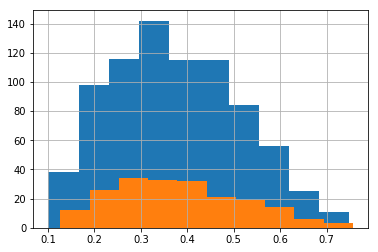

[2019-07-23 17:11:01,354] 
### Score Table for logistic regression to calculate propensity score:


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed conversion rate,predicted conversion rate
train,800,2,0.65875,0.591195,0.311258,0.407809,0.590368,0.3775,0.19875
test,200,2,0.70000,0.674419,0.386667,0.491525,0.637333,0.3750,0.21500


[2019-07-23 17:11:01,383] 
### Confusion Matrix for Train:


,Pred_0,Pred_1
True_0,433,65
True_1,208,94


[2019-07-23 17:11:01,391] 
### Confusion Matrix for Test:


,Pred_0,Pred_1
True_0,111,14
True_1,46,29


[2019-07-23 17:11:01,406] ### Treatment fraction in train dataset: 0.3775
[2019-07-23 17:11:01,407] ### Treatment fraction in test dataset: 0.375


In [13]:
print('\n[Estimate propensity scores for Inverse Probability Weighting.]')
cl = CausalLift(train_df, test_df, enable_ipw=True, random_state=0, verbose=3)

In [14]:
print('\n[Create 2 models for treatment and untreatment and estimate CATE (Conditional Average Treatment Effects)]')
train_df, test_df = cl.estimate_cate_by_2_models()

print('\n[Show CATE for train dataset]')
display(train_df)
train_df.to_csv('CATE_for_Train.csv')

print('\n[Show CATE for test dataset]')
display(test_df)
test_df.to_csv('CATE_for_Test.csv')


[Create 2 models for treatment and untreatment and estimate CATE (Conditional Average Treatment Effects)]
[2019-07-23 17:11:01,476] [Run option] runner: SequentialRunner, run_only_missing: False
[2019-07-23 17:11:01,483] Running node: model_for_treated_fit([args,df_01]) -> [treated__model_dict]
[2019-07-23 17:11:01,485] 

## Model for Treatment = 1.0
[2019-07-23 17:11:01,577] ### Best parameters of the model trained using samples with observational Treatment: 1.0 
 {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'verbose': 0}
[2019-07-23 17:11:01,588] 
### Feature importances of the model trained using samples with observational Treatment: 1.0


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


,0,1,2
feature importance,0.475212,0.172134,0.352654


[2019-07-23 17:11:01,619] 
### Outcome estimated by the model trained using samples with observational Treatment: 1.0


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed conversion rate,predicted conversion rate
train,302,2,1.000000,1.0,1.000000,1.000000,1.000000,0.364238,0.364238
test,75,2,0.973333,1.0,0.935484,0.966667,0.967742,0.413333,0.386667


[2019-07-23 17:11:01,637] Running node: model_for_untreated_fit([args,df_01]) -> [untreated__model_dict]
[2019-07-23 17:11:01,638] 

## Model for Treatment = 0.0
[2019-07-23 17:11:01,748] ### Best parameters of the model trained using samples with observational Treatment: 0.0 
 {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'verbose': 0}
[2019-07-23 17:11:01,757] 
### Feature importances of the model trained using samples with observational Treatment: 0.0


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


,0,1,2
feature importance,0.241133,0.321849,0.437018


[2019-07-23 17:11:01,787] 
### Outcome estimated by the model trained using samples with observational Treatment: 0.0


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed conversion rate,predicted conversion rate
train,498,2,1.000,1.0,1.00,1.000000,1.000,0.072289,0.072289
test,125,2,0.976,1.0,0.75,0.857143,0.875,0.096000,0.072000


[2019-07-23 17:11:01,808] Running node: bundle_treated_and_untreated_models([treated__model_dict,untreated__model_dict]) -> [models_dict]
[2019-07-23 17:11:01,836] [Run option] runner: SequentialRunner, run_only_missing: False
[2019-07-23 17:11:01,856] Running node: model_for_treated_predict_proba([args,df_01,models_dict]) -> [treated__proba]
[2019-07-23 17:11:01,874] Running node: model_for_untreated_predict_proba([args,df_01,models_dict]) -> [untreated__proba]
[2019-07-23 17:11:01,886] [Run option] runner: SequentialRunner, run_only_missing: False
[2019-07-23 17:11:01,897] Running node: compute_cate([treated__proba,untreated__proba]) -> [cate_estimated]
[2019-07-23 17:11:01,901] [Run option] runner: SequentialRunner, run_only_missing: False
[2019-07-23 17:11:01,912] Running node: add_cate_to_df([args,cate_estimated,df_01]) -> [df_02]

[Show CATE for train dataset]


,0,1,2,Treatment,Outcome,Propensity,CATE
0,0.027653,0.660339,0.414439,1.0,1.0,0.568200,0.979456
1,0.389549,0.263768,0.944626,0.0,0.0,0.206363,0.998100
2,0.023237,0.531104,0.204781,0.0,1.0,0.603150,-0.017245
3,0.110477,0.405036,0.405374,1.0,1.0,0.471381,0.997414
...,...,...,...,...,...,...,...
796,0.584645,0.091271,0.600471,0.0,0.0,0.219878,0.524071
797,0.493945,0.929619,0.667215,1.0,0.0,0.443840,0.036610
798,0.356007,0.987435,0.013655,1.0,0.0,0.715760,-0.998410
799,0.980486,0.096451,0.863471,0.0,0.0,0.115201,0.502684



[Show CATE for test dataset]


,0,1,2,Treatment,Outcome,Propensity,CATE
0,0.083165,0.974774,0.049285,0.0,1.0,0.756486,-0.953304
1,0.599581,0.430181,0.909093,0.0,0.0,0.213857,0.503406
2,0.653421,0.726342,0.536923,1.0,0.0,0.388449,0.000039
3,0.099733,0.475589,0.820022,0.0,0.0,0.351978,0.999037
...,...,...,...,...,...,...,...
196,0.351035,0.800597,0.365044,1.0,0.0,0.547841,-0.127346
197,0.693592,0.673458,0.952937,0.0,0.0,0.239214,0.134086
198,0.117320,0.107004,0.589695,0.0,0.0,0.319266,0.999383
199,0.627735,0.401428,0.416692,0.0,0.0,0.340701,0.002220


In [15]:
print('\n[Estimate the effect of recommendation based on the uplift model]')
estimated_effect_df = cl.estimate_recommendation_impact()

print('\n[Show the estimated effect of recommendation based on the uplift model]')
display(estimated_effect_df)


[Estimate the effect of recommendation based on the uplift model]
[2019-07-23 17:11:02,032] [Run option] runner: SequentialRunner, run_only_missing: False
[2019-07-23 17:11:02,041] Running node: recommend_by_cate([args,df_02,treatment_fractions]) -> [df_03]
[2019-07-23 17:11:02,051] [Run option] runner: SequentialRunner, run_only_missing: False
[2019-07-23 17:11:02,067] Running node: model_for_treated_simulate_recommendation([args,df_03,models_dict]) -> [treated__sim_eval_df]
[2019-07-23 17:11:02,098] 
### Simulated outcome of samples recommended to be treatment: 1.0 by the uplift model:


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed conversion rate,predicted conversion rate
train,302,2,0.380795,0.352941,1.0,0.521739,0.5325,0.337748,0.956954
test,75,2,0.373333,0.373333,1.0,0.543689,0.5000,0.373333,1.000000


[2019-07-23 17:11:02,124] Running node: model_for_untreated_simulate_recommendation([args,df_03,models_dict]) -> [untreated__sim_eval_df]
[2019-07-23 17:11:02,153] 
### Simulated outcome of samples recommended to be treatment: 0.0 by the uplift model:


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed conversion rate,predicted conversion rate
train,498,2,0.919679,0.52381,1.000000,0.687500,0.955947,0.088353,0.168675
test,125,2,0.880000,0.50000,0.666667,0.571429,0.787879,0.120000,0.160000


[2019-07-23 17:11:02,178] [Run option] runner: SequentialRunner, run_only_missing: False
[2019-07-23 17:11:02,188] Running node: estimate_effect([treated__sim_eval_df,untreated__sim_eval_df]) -> [estimated_effect_df]
[2019-07-23 17:11:02,200] 
### Treated samples without and with uplift model:


,# samples chosen without uplift model,observed conversion rate without uplift model,# samples recommended by uplift model,predicted conversion rate using uplift model,predicted improvement rate
train,302,0.364238,302,0.956954,2.627273
test,75,0.413333,75,1.000000,2.419355


[2019-07-23 17:11:02,209] 
### Untreated samples without and with uplift model:


,# samples chosen without uplift model,observed conversion rate without uplift model,# samples recommended by uplift model,predicted conversion rate using uplift model,predicted improvement rate
train,498,0.072289,498,0.168675,2.333333
test,125,0.096000,125,0.160000,1.666667



[Show the estimated effect of recommendation based on the uplift model]


,# samples,observed conversion rate without uplift model,predicted conversion rate using uplift model,predicted improvement rate
train,800,0.1825,0.46625,2.554795
test,200,0.2150,0.47500,2.209302


Targeting based on recommendation by uplift model is predicted to increase the conversion rate by 2.209 times (0.215 to 0.475) on the test portion of simulated observational data!